In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import chess
import numpy as np

ModuleNotFoundError: No module named 'chess'

In [3]:
import time

In [4]:
def check_status(key):
    board = chess.Board()
    key = key + ' - - 0 1'
    board.set_fen(key)
    return board.is_game_over()

def draw_board(board, key):
    key = key + ' - - 0 1'
    board.set_fen(key)
    display(board)
    print(board.is_game_over())

In [5]:
def get_next_state(board, move):
    board.push(move)
    fen = ' '.join(board.fen().split(' ')[:2])
    status = int(board.is_checkmate())
    board.pop()
    return fen, -status

In [6]:
def get_states():
    board = chess.Board()
    states = {}
    N = 64
    for k in range(N):
        # Rey negro
        for j in range(N):
            # Rey blanco
            for i in range(N):
                # Torre blanca
                board.clear()
                board.set_piece_at(i, chess.Piece(chess.ROOK, True))
                board.set_piece_at(j, chess.Piece(chess.KING, True))
                board.set_piece_at(k, chess.Piece(chess.KING, False))
                board.turn = True
                
                if board.status() == chess.Status.VALID and not board.is_game_over():
                    fen = ' '.join(board.fen().split(' ')[:2])
                    states[fen]={}
                    for move in board.legal_moves:
                        states[fen][str(move)] = {}
                        new_fen, status = get_next_state(board, move)
                        states[fen][str(move)]['next_state'] = new_fen
                        states[fen][str(move)]['status'] = status

                board.turn = False

                if board.status() == chess.Status.VALID and not board.is_game_over():
                    fen = ' '.join(board.fen().split(' ')[:2])
                    states[fen]={}
                    for move in board.legal_moves:
                        states[fen][str(move)] = {}
                        new_fen, status = get_next_state(board, move)
                        states[fen][str(move)]['next_state'] = new_fen
                        states[fen][str(move)]['status'] = status
    return states

In [192]:
%time states = get_states()

CPU times: user 7min 32s, sys: 5.5 s, total: 7min 37s
Wall time: 7min 45s


In [7]:
states = np.load('rook_final.npy').item()
# np.save('rook_final', states)

In [8]:
def get_deterministic_policy(states):
    pi = {}
    for state, value in states.items():
        pi[state] = list(value.keys())[0]
    return pi

def init_V(states_actions):
    return {state:0 for state in states_actions}

def deterministic_policy_eval_step(states_actions, V, pi):
    # Evaluation in place (in contrast with evaluation with 2 arrays).
    # Needs less memory and converges too
    # pi is a dict and pi[s] is the best action for that state. (The most probable action)
    delta = 0
    for state, actions in states_actions.items():
        action = pi[state]
        next_node = actions[action]['next_state']
        reward = actions[action]['status']
        V_updated = 0
        if next_node in V:
            V_updated = -(reward + V[next_node])
        else:
            V_updated = -reward
#         if next_node in V and reward == 0:
#             V_updated = (-V[next_node])
#         else:
#             # Esto es un nodo terminal
#             V_updated = - reward
        delta = max(delta, np.abs(V_updated - V[state]))
        V[state] = V_updated
    return V, delta

In [14]:
def policy_improve(V, states_actions):
    pi = {}
    for state, actions in states_actions.items():
        actions_list = [] # list(actions.keys())
        expected_rewards = [] #np.zeros(len(actions))
        for i, (action, data) in enumerate(actions.items()):
            actions_list.append(action)
            next_state = data['next_state']
            reward = data['status']
            if next_state in V:
                expected_rewards.append(-(reward + V[next_state]))
            else:
                expected_rewards.append(-reward)
            
#             if next_state in V and reward == 0:
#                 expected_rewards[i] = - V[next_state]
#             else:
#                 # Esto es un nodo terminal
#                 expected_rewards[i] = - reward
        if state == '4k3/8/4K2R/8/8/8/8/8 w':
            print(actions_list)
            print(expected_rewards)
        pi[state] = actions_list[np.argmax(expected_rewards)]
    return pi

In [17]:
from dynamic_programming import policy_iteration

In [18]:
pi = get_deterministic_policy(states)
pi, V = policy_iteration(states, 
                             pi, 
                             deterministic_policy_eval_step = deterministic_policy_eval_step, 
                             policy_improve=policy_improve, 
                             verbose = 1)

Iteration number:  1 2 3 4 5 
['h6h8', 'h6h7', 'h6g6', 'h6f6', 'h6h5', 'h6h4', 'h6h3', 'h6h2', 'h6h1', 'e6f6', 'e6d6', 'e6f5', 'e6e5', 'e6d5']
[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Number of differences of new policy vs old policy: 3905
---------------------------
Iteration number:  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 
['h6h8', 'h6h7', 'h6g6', 'h6f6', 'h6h5', 'h6h4', 'h6h3', 'h6h2', 'h6h1', 'e6f6', 'e6d6', 'e6f5', 'e6e5', 'e6d5']
[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Number of differences of new policy vs old policy: 53045
---------------------------
Iteration number:  1 2 3 

KeyboardInterrupt: 

In [15]:
# def policy_evaluation(policy_eval_step, states_actions, pi, theta, verbose=0):
#     if verbose:
#         print('Iteration number: ', end=' ')
#     iters = 0
#     V = init_V(states_actions)
#     ## Solo para que entre en el while
#     delta = theta + 1
#     while theta<delta: 
#         V, delta = policy_eval_step(states_actions, V, pi)
#         iters += 1
#         if verbose:
#             print((iters, sum(abs(np.array(list(V.values()))))), end=' ')
#     return V, iters

In [16]:
# def policy_iteration(states_actions, pi, deterministic_policy_eval_step = deterministic_policy_eval_step, policy_improve=policy_improve, verbose = 0):
#     # Politica inicial
#     policy_updates = 100
#     pi_old = pi.copy()
#     while policy_updates > 0:
#         # Calculo values de politica
#         V, iters = policy_evaluation(deterministic_policy_eval_step, states_actions, pi_old, 1e-6, verbose=verbose)
#         # Mejoro política con values
#         pi = policy_improve(V, states_actions)

#         policy_updates = 0
#         for j, (state, accion) in enumerate(pi.items()):
#             if accion != pi_old[state]:
#                  policy_updates += 1
#         pi_old = pi.copy()
#         if verbose:
#             print('Number of differences of new policy vs old policy:', policy_updates)
#             print('---------------------------')
#     return pi_old, V

In [122]:
pi = get_deterministic_policy(states)

In [123]:
V, iters = policy_evaluation(deterministic_policy_eval_step, states, pi, 1e-6, verbose=1)

Iteration number:  (1, 155) (2, 247) (3, 392) (4, 540) (5, 540) 

In [90]:
def secuencia_hasta_el_final(state = '8/8/8/8/8/5KR1/8/6k1 b'):
    board = chess.Board()
    board.set_fen(state + ' - - 0 1')
    display(board)
    print(V[state])

    while True:
        next_move = list(states[state].keys())[0]
        board.set_fen(state + ' - - 0 1' )
        board.push_uci(next_move)
        display(board)
        state = ' '.join(board.fen().split(' ')[:2])
        if state not in V:
            break
        print(V[state])

In [115]:
#secuencia_hasta_el_final(state = '8/R7/5K2/8/7k/8/8/8 b')

In [110]:
# for state, value in V.items():
#     if value!=0:
#         # get_next_state(state)
#         board.set_fen(state + ' - - 0 1' )
#         board.push_uci(list(states[state].keys())[0])
#         if not board.is_checkmate():
#             print(state, value)
#             display(board)

In [229]:
V['4k3/8/4K2R/8/8/8/8/8 w']

0

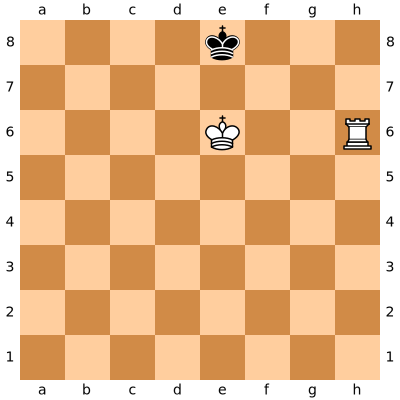

False


In [230]:
draw_board(board, '4k3/8/4K2R/8/8/8/8/8 w')

In [225]:
V = init_V(states)
pi = policy_improve(V, states)
states['4k3/8/4K2R/8/8/8/8/8 w']

['h6h8', 'h6h7', 'h6g6', 'h6f6', 'h6h5', 'h6h4', 'h6h3', 'h6h2', 'h6h1', 'e6f6', 'e6d6', 'e6f5', 'e6e5', 'e6d5'] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


{'h6h8': {'next_state': '4k2R/8/4K3/8/8/8/8/8 b', 'status': -1},
 'h6h7': {'next_state': '4k3/7R/4K3/8/8/8/8/8 b', 'status': 0},
 'h6g6': {'next_state': '4k3/8/4K1R1/8/8/8/8/8 b', 'status': 0},
 'h6f6': {'next_state': '4k3/8/4KR2/8/8/8/8/8 b', 'status': 0},
 'h6h5': {'next_state': '4k3/8/4K3/7R/8/8/8/8 b', 'status': 0},
 'h6h4': {'next_state': '4k3/8/4K3/8/7R/8/8/8 b', 'status': 0},
 'h6h3': {'next_state': '4k3/8/4K3/8/8/7R/8/8 b', 'status': 0},
 'h6h2': {'next_state': '4k3/8/4K3/8/8/8/7R/8 b', 'status': 0},
 'h6h1': {'next_state': '4k3/8/4K3/8/8/8/8/7R b', 'status': 0},
 'e6f6': {'next_state': '4k3/8/5K1R/8/8/8/8/8 b', 'status': 0},
 'e6d6': {'next_state': '4k3/8/3K3R/8/8/8/8/8 b', 'status': 0},
 'e6f5': {'next_state': '4k3/8/7R/5K2/8/8/8/8 b', 'status': 0},
 'e6e5': {'next_state': '4k3/8/7R/4K3/8/8/8/8 b', 'status': 0},
 'e6d5': {'next_state': '4k3/8/7R/3K4/8/8/8/8 b', 'status': 0}}

In [226]:
V['4k3/8/4K2R/8/8/8/8/8 w']

0

In [52]:
check_status('4k3/8/4K2R/8/8/8/8/8 w')

False

In [206]:
states['4kR2/8/4K3/8/8/8/8/8 b']

{'e8f8': {'next_state': '5k2/8/4K3/8/8/8/8/8 w', 'status': 0}}

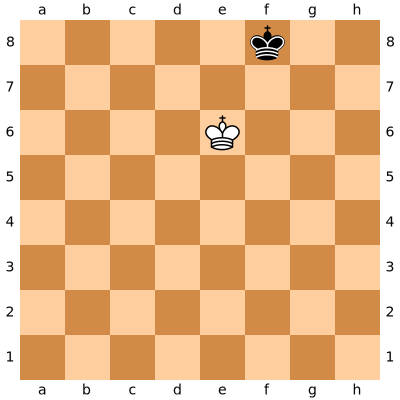

True


In [210]:
draw_board(board, '5k2/8/4K3/8/8/8/8/8 b')

In [80]:
# np.save('rook_final', states)

In [83]:
8/8/8/8/8/2K2R2/8/2k/5 w 

-rw-r--r--  1 julianganzabal  staff   272M Mar 15 16:25 rook_final.npy


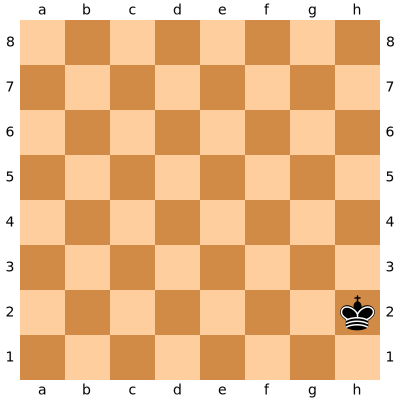

In [32]:
board

In [23]:
len(states)

436892

In [5]:
len(states)

516224

In [20]:
chess.Status.VALID == board.status()

True

In [19]:
board.clear()
board.set_piece_at(0, chess.Piece(chess.ROOK, True))
board.set_piece_at(10, chess.Piece(chess.KING, True))
board.set_piece_at(15, chess.Piece(chess.KING, False))
            
print(board.status())
print(board.is_game_over())


Status.VALID
False


In [73]:
board.is_checkmate()

False

In [499]:
def get_Bishop_Final():
    board = chess.Board()
    board.clear()
    board.set_piece_at(3, chess.Piece(3, True))
    board.set_piece_at(4, chess.Piece(3, True))
    board.set_piece_at(60, chess.Piece(6, False))
    board.set_piece_at(0, chess.Piece(6, True))
    return board

In [489]:
board = get_Bishop_Final()

In [491]:
print(board)

. . . . k . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
K . . B B . . .


In [498]:
board.fen()

'4k3/8/8/8/8/8/8/K2BB3 w - - 0 1'

In [486]:
states = {}
states[board.fen()] = 0

In [72]:
who(not True)

No variables match your requested type.


In [487]:
def random_move(board):
    move = np.random.choice(list(board.legal_moves))
    board.push(move)
    states[board.fen()] = 0
    game_over = board.is_game_over()
    msg = ''
    if game_over:
        if board.is_checkmate():
            msg = "checkmate: " + who(not board.turn) + " wins!"
            result = not board.turn
        elif board.is_stalemate():
            msg = "draw: stalemate"
        elif board.is_fivefold_repetition():
            msg = "draw: 5-fold repetition"
        elif board.is_insufficient_material():
            msg = "draw: insufficient material"
        elif board.can_claim_draw():
            msg = "draw: claim"
    return board, game_over, msg

In [492]:
import time
from IPython.display import display, HTML, clear_output

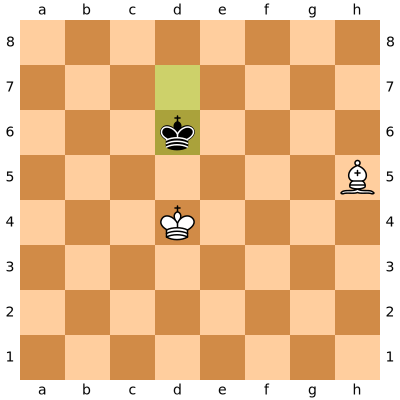

draw: insufficient material


In [482]:
board = get_Bishop_Final()
display(board._repr_svg_())
game_over = False
while not game_over:
    time.sleep(0.1)
    board, game_over, msg = random_move(board)
    clear_output(wait=True)
    display(board._repr_svg_())
print(msg)

In [397]:
for legal_move in board.legal_moves:
    move = chess.Move.from_uci(str(legal_move))
    print(move)

f2a7
f2b6
f2c5
f2h4
f2d4
f2g3
f2e3
f2g1
f2e1
d1h5
d1g4
d1a4
d1f3
d1b3
d1e2
d1c2
a1b2
a1a2
a1b1


In [129]:
board.push(move)

In [131]:
board.pop()

Move.from_uci('a1b1')

In [132]:
board.fen()

'4k3/8/8/8/8/8/8/K2BB3 w - - 0 1'

In [128]:
board.fen()

'4k3/8/8/8/8/8/8/K2BB3 w - - 0 1'

In [ ]:
chess.Move.from_uci()

In [77]:
chess.Move.from_uci("a1a2") in board.legal_moves

True

In [73]:
Nf3 = chess.Move.from_uci("g1f3")

In [74]:
board.push(Nf3)

In [ ]:
board.